Iniciando varredura em 'repositories-mined'...


Processando repositórios: 100%|██████████| 13/13 [00:03<00:00,  4.06it/s]
/tmp/ipykernel_28196/267705514.py:137: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='faixa', y='tempo_merge_horas',



Total de PRs coletados: 73325


--- Resumo dos Dados ---

--- Tempo Médio para Merge por Faixa (em horas) ---
faixa
E    319.27
D    291.56
C    365.60
B    272.71
A    118.17
Name: tempo_merge_horas, dtype: float64

--- Taxa de Sucesso da CI por Faixa ---
faixa
E    0.118
D    0.085
C    0.114
B    0.144
A    0.184
Name: ci_sucesso, dtype: float64

--- Hora Média de Criação ---
faixa
E    12.96
D    13.13
C    12.59
B    12.74
A    13.20
Name: hora_criacao, dtype: float64

--- Dia Médio de Criação (0=Segunda) ---
faixa
E    2.76
D    2.67
C    2.75
B    2.53
A    2.44
Name: dia_semana_criacao, dtype: float64

--- Gerando Gráficos de Análise de Eficiência ---


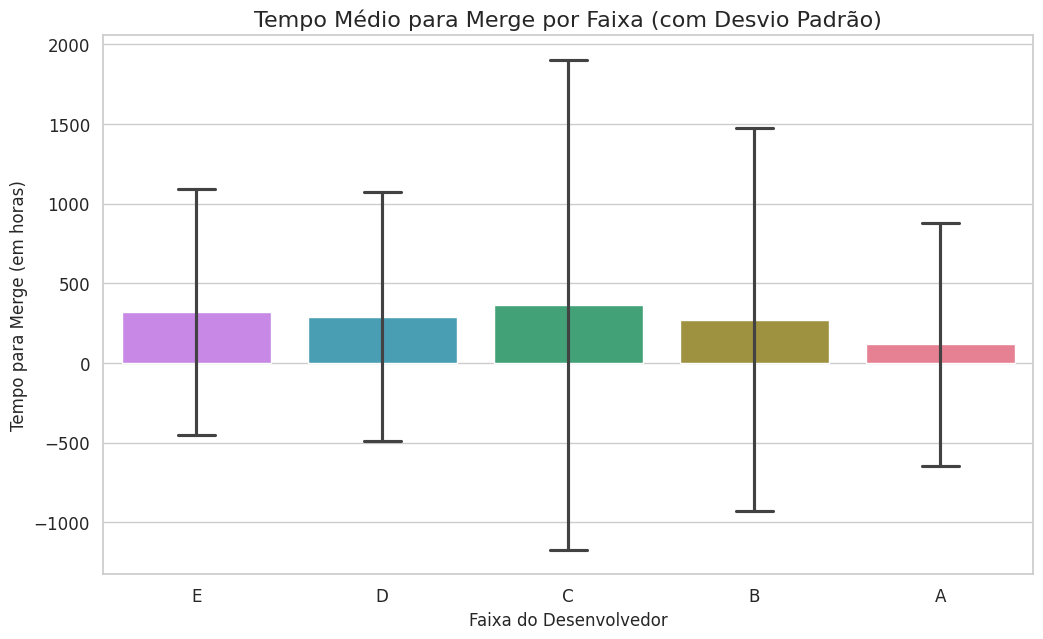

/tmp/ipykernel_28196/267705514.py:148: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_ci.index, y=df_ci.values, palette=paleta_consistente)


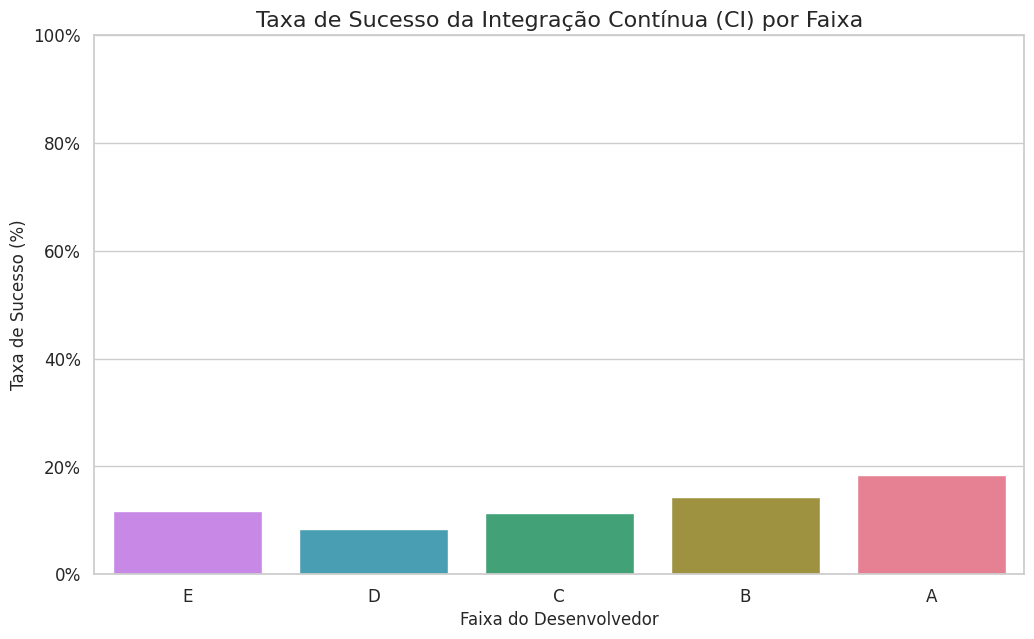

/tmp/ipykernel_28196/267705514.py:159: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='faixa', y='hora_criacao', order=ordem_graficos, palette=paleta_consistente)


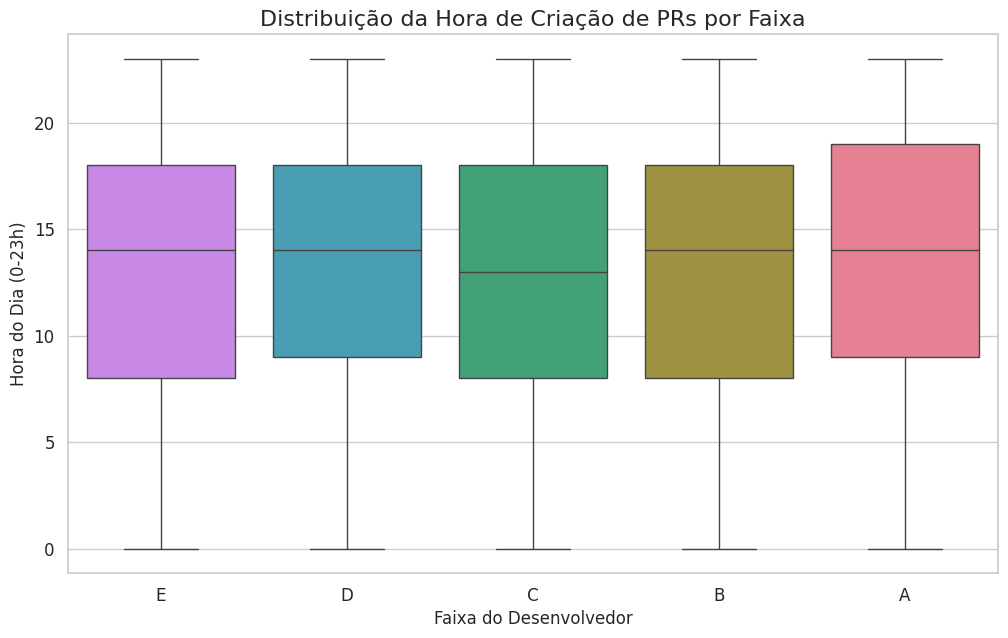

/tmp/ipykernel_28196/267705514.py:167: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='faixa', y='dia_semana_criacao', order=ordem_graficos, palette=paleta_consistente)


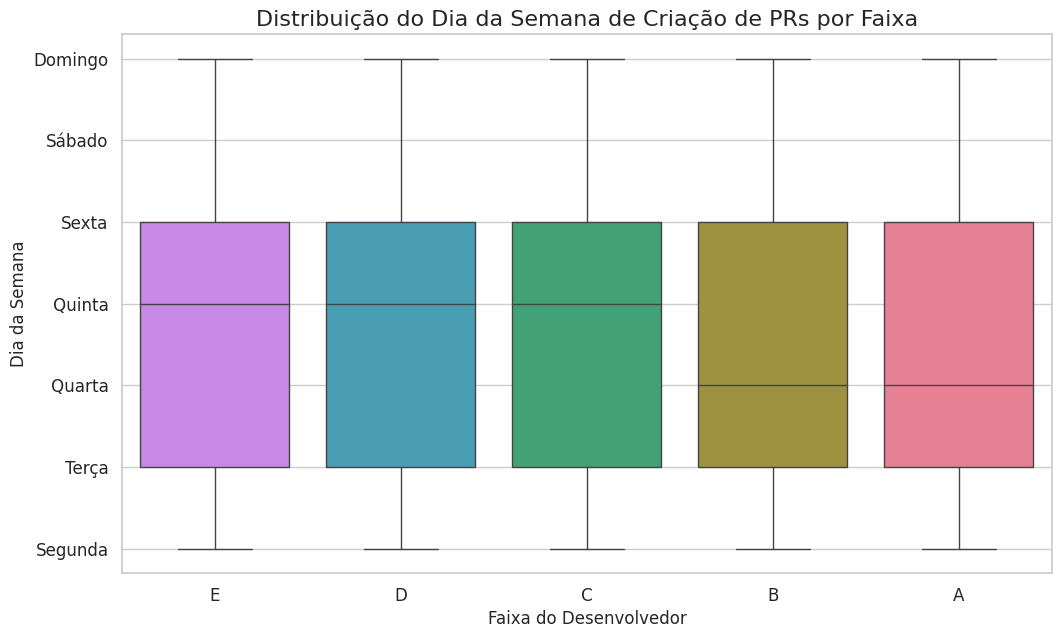


Análise finalizada.


In [3]:
import os
import json
import random
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm # Adicionado para melhor feedback visual

# --- 1. Configuração e Carregamento de Dados ---
# Caminho base
base_path = "repositories-mined"

# Armazenamento dos dados de PRs
todos_os_prs = []

print(f"Iniciando varredura em '{base_path}'...")

# Lista de repositórios para iterar com uma barra de progresso
repo_list = [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]

# Percorre cada repositório
for repo in tqdm(repo_list, desc="Processando repositórios"):
    repo_path = os.path.join(base_path, repo)

    # Lê os autores do arquivo de amostra
    sample_path = os.path.join(repo_path, "sample-devs.jsonl")
    if not os.path.isfile(sample_path):
        continue

    # Carrega os desenvolvedores da amostra para este repositório
    devs_neste_repo = {}
    with open(sample_path, 'r', encoding='utf-8') as f:
        for line in f:
            dev_data = json.loads(line)
            devs_neste_repo[dev_data['author'].lower()] = dev_data['faixa']

    # Percorre a pasta de desenvolvedores para encontrar os PRs
    devs_folder_path = os.path.join(repo_path, "developer")
    if not os.path.isdir(devs_folder_path):
        continue

    for dev_name in os.listdir(devs_folder_path):
        # Verifica se este desenvolvedor está na nossa amostra
        if dev_name.lower() in devs_neste_repo:
            faixa = devs_neste_repo[dev_name.lower()]
            results_path = os.path.join(devs_folder_path, dev_name, "results")

            if not os.path.isdir(results_path):
                continue

            for arquivo_json in os.listdir(results_path):
                if not arquivo_json.endswith(".json"):
                    continue

                caminho_arquivo = os.path.join(results_path, arquivo_json)

                try:
                    with open(caminho_arquivo, 'r', encoding='utf-8') as f:
                        pr = json.load(f)

                    # Adiciona informações extra que serão úteis na análise
                    pr['author'] = dev_name
                    pr['faixa'] = faixa
                    pr['repo'] = repo
                    todos_os_prs.append(pr)
                except Exception as e:
                    print(f"Aviso: Erro ao ler o arquivo {caminho_arquivo}: {e}")

print(f"\nTotal de PRs coletados: {len(todos_os_prs)}")

# --- 2. Análise de Eficiência e Processamento de Dados ---
def analisar_eficiencia(prs):
    """
    Processa a lista de PRs brutos e extrai métricas de eficiência.
    """
    registros = []

    for pr in prs:
        try:
            # Converte as strings de data para objetos datetime
            created_at = datetime.fromisoformat(pr['created_at'].replace("Z", "+00:00"))
        except (ValueError, TypeError):
            continue # Pula o PR se a data de criação for inválida

        merged_at = pr.get("merged_at")
        tempo_merge = None
        if merged_at:
            try:
                merged = datetime.fromisoformat(merged_at.replace("Z", "+00:00"))
                # Calcula a diferença em horas
                tempo_merge = (merged - created_at).total_seconds() / 3600
            except (ValueError, TypeError):
                pass # Ignora se a data de merge for inválida

        # Processa o status da Integração Contínua (CI)
        ci_status = pr.get("ci_status_on_head", "unknown")
        ci_sucesso = 1 if ci_status == "success" else 0
        # Considera um status de CI válido se for um dos três esperados
        ci_valido = ci_status in ["success", "failure", "pending"]

        registros.append({
            "faixa": pr["faixa"],
            "tempo_merge_horas": tempo_merge,
            "ci_status": ci_status,
            "ci_sucesso": ci_sucesso,
            "ci_valido": ci_valido,
            "hora_criacao": created_at.hour,
            "dia_semana_criacao": created_at.weekday(), # 0=Segunda, 6=Domingo
        })

    return pd.DataFrame(registros)

df = analisar_eficiencia(todos_os_prs)

# --- 3. Configuração de Visualização ---
# Paleta de cores consistente para garantir que a Faixa A sempre tenha a mesma cor, etc.
ordem_faixas_original = ["A", "B", "C", "D", "E"]
ordem_graficos = ["E", "D", "C", "B", "A"] # Ordem invertida para visualização

cores_husl = sns.color_palette("husl", len(ordem_faixas_original))
paleta_consistente = dict(zip(ordem_faixas_original, cores_husl))

# Define um estilo global para os gráficos
sns.set(style="whitegrid", font_scale=1.1, rc={"figure.figsize": (12, 7)})


# --- 4. Geração e Exibição de Gráficos ---
def gerar_graficos(df):
    """
    Gera e exibe os gráficos da análise de eficiência diretamente no notebook.
    """
    print("\n--- Gerando Gráficos de Análise de Eficiência ---")

    # --- Gráfico 1: Tempo médio para merge ---
    plt.figure() # Cria uma nova figura para o gráfico
    sns.barplot(data=df, x='faixa', y='tempo_merge_horas',
                order=ordem_graficos, errorbar='sd', palette=paleta_consistente, capsize=.2)
    plt.title("Tempo Médio para Merge por Faixa (com Desvio Padrão)", fontsize=16)
    plt.xlabel("Faixa do Desenvolvedor", fontsize=12)
    plt.ylabel("Tempo para Merge (em horas)", fontsize=12)
    plt.show()

    # --- Gráfico 2: Taxa de sucesso da CI ---
    plt.figure()
    # Calcula a média de sucesso (1s e 0s) para cada faixa
    df_ci = df[df["ci_valido"]].groupby("faixa")["ci_sucesso"].mean().reindex(ordem_graficos)
    sns.barplot(x=df_ci.index, y=df_ci.values, palette=paleta_consistente)
    plt.title("Taxa de Sucesso da Integração Contínua (CI) por Faixa", fontsize=16)
    plt.xlabel("Faixa do Desenvolvedor", fontsize=12)
    plt.ylabel("Taxa de Sucesso (%)", fontsize=12)
    plt.ylim(0, 1) # Define o eixo Y de 0 a 100%
    # Formata o eixo Y para mostrar porcentagens
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
    plt.show()

    # --- Gráfico 3: Distribuição da Hora de criação ---
    plt.figure()
    sns.boxplot(data=df, x='faixa', y='hora_criacao', order=ordem_graficos, palette=paleta_consistente)
    plt.title("Distribuição da Hora de Criação de PRs por Faixa", fontsize=16)
    plt.xlabel("Faixa do Desenvolvedor", fontsize=12)
    plt.ylabel("Hora do Dia (0-23h)", fontsize=12)
    plt.show()

    # --- Gráfico 4: Distribuição do Dia da semana de criação ---
    plt.figure()
    sns.boxplot(data=df, x='faixa', y='dia_semana_criacao', order=ordem_graficos, palette=paleta_consistente)
    plt.title("Distribuição do Dia da Semana de Criação de PRs por Faixa", fontsize=16)
    plt.xlabel("Faixa do Desenvolvedor", fontsize=12)
    plt.ylabel("Dia da Semana", fontsize=12)
    plt.yticks(ticks=range(7), labels=["Segunda", "Terça", "Quarta", "Quinta", "Sexta", "Sábado", "Domingo"])
    plt.show()

# --- 5. Execução e Exibição de Resumos ---
if not df.empty:
    # Exibir resumo no console
    print("\n\n--- Resumo dos Dados ---")
    print("\n--- Tempo Médio para Merge por Faixa (em horas) ---")
    print(df.groupby('faixa')['tempo_merge_horas'].mean().reindex(ordem_graficos).round(2))

    print("\n--- Taxa de Sucesso da CI por Faixa ---")
    print(df[df["ci_valido"]].groupby('faixa')['ci_sucesso'].mean().reindex(ordem_graficos).round(3))

    print("\n--- Hora Média de Criação ---")
    print(df.groupby('faixa')['hora_criacao'].mean().reindex(ordem_graficos).round(2))

    print("\n--- Dia Médio de Criação (0=Segunda) ---")
    print(df.groupby('faixa')['dia_semana_criacao'].mean().reindex(ordem_graficos).round(2))

    # Gerar e exibir os gráficos
    gerar_graficos(df)
else:
    print("\nNenhum dado válido foi processado para gerar os gráficos.")

print("\nAnálise finalizada.")